In [1]:
# Set Up
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
from PIL import Image
# img = Image.open('../cars1.ppm')
# img.show()

# img = Image.open('../cars2.ppm')
# img.show()

In [80]:
def scale_img(img, scale_percent):
    print("scale_img()")
    print(img.shape)
    # Scale down image
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    print(img.shape)
    return img

In [81]:
# show grayscale image
def show_grayscale( my_image ):
    plt.figure(figsize = (10,10))
    plt.imshow(my_image, cmap = plt.get_cmap(name = 'gray'))
    plt.show()

In [ ]:
# computer gradient using sobel
def get_gradient(img):
    print("get_gradient()")
    padding = 1
    (y,x) = img.shape
    Ix = np.zeros(img.shape)
    Iy = np.zeros(img.shape)
    
    print("before padding: ",img.shape)
    padded_img = np.pad(img, padding)
    print("after padding: ",padded_img.shape)
    
    horiz = np.array([[-1, 0, 1]])
    vert  = np.array([[-1], [0], [1]])

    #print(padded_img[int(x)][int(y)])
    
    # Filter the image using sobel
    # Iterate across rows, then columns, computing gradient, remember this image is padded!
    for j in range( padding, padding + int(y)):
        for i in range( padding, padding + int(x)):
            #print(j, i)
            Ix[j-padding, i-padding] = horiz[0,0]*padded_img[j,i-1] + horiz[0, 1]*padded_img[j, i] + horiz[0, 2]*padded_img[j, i+1]
            Iy[j-padding, i-padding] = vert[0]*padded_img[j-1, i]  + vert[1]*padded_img[j, i]  + vert[2]*padded_img[j+1, i]
    return (Ix, Iy)

In [190]:
# detect key points using openCV FAST or SURF
# Limit # of detected Kepoints <= 100
def get_kp( img, Suppress = False):
    print("get_kp()")
    print(type(img))
    print(img.shape)

    # Initiate FAST object with default values
    fast = cv.FastFeatureDetector_create()
    
    # Disable nonmaxSuppression
    if (Suppress == False):
        fast.setNonmaxSuppression(0)
    
    # find and draw the keypoints
    kp = fast.detect(img,None)
    # KP structure documentation: https://docs.opencv.org/master/d2/d29/classcv_1_1KeyPoint.html
    
    kp_img = cv.drawKeypoints(img, kp, None, color=(255,0,0))
    
    # Print all default params
    print( "\nThreshold: {}".format(fast.getThreshold()) )
    print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
    print( "neighborhood: {}".format(fast.getType()) )
    print( "Total Keypoints {}".format(len(kp)) )
    
    # print image
    show_grayscale(kp_img)
    
    return kp

In [201]:
# Gets 5x5 window extraction around a given keypoint data structure
def get_5x5_window( image, this_kp, padding = 0):
    #print("get_5x5_window()")
    padded_img = np.pad(image, padding)
    fd_window = np.zeros((5,5))
    
    (x, y) = this_kp.pt
    #print(this_kp.pt)
    #print(padded_img[int(x)][int(y)])
    
    # gather raw pixel data around kp coordinate
    for j in range( padding + int(y) - 2, padding + int(y) + 3):
        for i in range( padding + int(x) - 2, padding + int(x) + 3):
            #print(i,j)
            #print(padded_img[i][j])
            fd_window[j%(padding + int(y) - 2), i%(padding + int(x) - 2)] = padded_img[j, i]
            
    #print(fd_window)
    return fd_window

In [202]:
# returns vector of 5x5 windows for a given image
def get_fdvector_5x5(img, kp_list):
    fd_vector = []
    for kp in kp_list:
        fd_vector.append(get_5x5_window(img, kp))
    return fd_vector

scale_img()
(682, 1416)
(341, 708)
get_kp()
<class 'numpy.ndarray'>
(341, 708)

Threshold: 10
nonmaxSuppression:False
neighborhood: 2
Total Keypoints 70


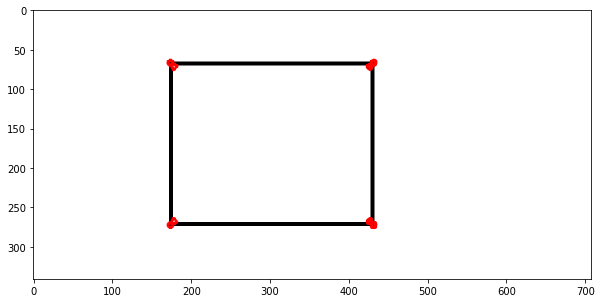

scale_img()
(682, 1416)
(341, 708)
get_kp()
<class 'numpy.ndarray'>
(341, 708)

Threshold: 10
nonmaxSuppression:False
neighborhood: 2
Total Keypoints 70


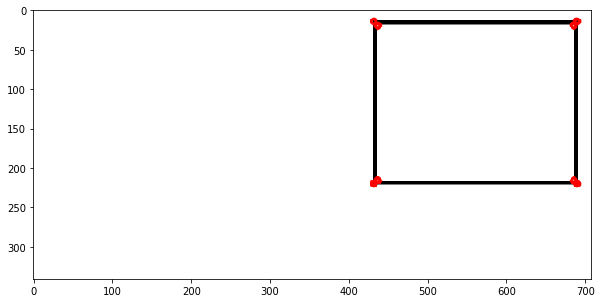

In [203]:
# image is a 2D numpy.ndarray
#img = np.array(Image.open( 'House.png').convert('L'))
img = np.array(Image.open( 'Square.png').convert('L'))

img= scale_img(img, 50)
kp = get_kp(img, Suppress=False)

img_t = np.array(Image.open( 'House_translation.png').convert('L'))
img_t = np.array(Image.open( 'Square_translation.png').convert('L'))

img_t= scale_img(img_t, 50)
kp_t = get_kp(img_t, Suppress=False)

In [204]:
# Get Feature Descriptor 5 X 5
# Test on translated image, use Paint to create a Box, then move the box to the right

# build 5x5 window vector
# List of windows
fd_vector = get_fdvector_5x5(img, kp)
print("length of fd vector: \t\t",len(fd_vector))
fd_vector_t = get_fdvector_5x5(img_t, kp)
print("length of fd vector translated: ",len(fd_vector_t))

length of fd vector: 		 70
length of fd vector translated:  70


In [ ]:
# compute matching

#get gradient
(Ix, Iy) = get_gradient(img)

In [93]:
# Implement SIFT like feature descriptor
# no orientation normalization if no rotation is involved